# Continuous Spatial Models

## Install required libraries

In [1]:
#!pip install -r requirements.txt

In [2]:
from src_import.modules import *
from src_import.func import *
plt.style.use('seaborn-poster')

/Users/giulia/anaconda3/lib/python3.7/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


# Continous spatial models

The meuse dataset in the R package <b>gstat</b> (Pebesma, 2004) contains measurements of heavy metals concentrations in the area of the Meuse river, near the village of Stein (The Netherlands). In addition, the meuse.grid dataset in the R package <b>sp</b> (Bivand, 2013) records the distance to the Meuse river and the soil type in a regular grid over the study region. These can be used in order to predict the concentration of heavy metals at any point of the study region.

The Coordinate Reference System (CRS) is the Netherlands topographical map, and the coordinates are measured in meters.

|Variable |	Description|
| --- | --- |
cadmium  |	Topsoil cadmium concentration (in ppm)
copper  |	Topsoil copper concentration (in ppm)
lead |	Topsoil lead concentration (in ppm)
zinc |	Topsoil zinc concentration (in ppm)
elev |	Relative elevation above local river bed (in meters)
dist |	Disance to the Meuse river (normalised to  (0,1))
om  |	Organic matter (in percentage)
ffreq  |	Flooding frequency (1 = once in two years; 2 = once in ten years; 3 = once in 50 years)
soil  |	Soil type (1 = Rd10A; 2 = Rd90C/VII; 3 = Bkd26/VII)
lime |	Lime class (0 = absent; 1 = present)
landuse |	Landuse class
dist.m |	Distance to the river (in meters)

Here we want to estimate the concentration of zinc in the study region as a function of the distance from the Meuse river
    
$$zinc\,(\mathbf{s}) \sim f\big(dist\,(\mathbf{s}) + u\,(\mathbf{s})\big)$$ 

### Let's read in the data

In [3]:
meuse = MEUSE()

### Let's plot the data

In [4]:
ramp = str(list(np.linspace(start=4, stop=8, num=11)))
ramp_str = f'opacity(ramp(buckets($log_zinc,' + ramp + '), Temps), .5)'
Map(
        Layer(meuse.data_lonlat,
            f'color: {ramp_str}',
            {'click': [{
                'title': '',
                'value': f'$log_zinc'
            }]},
            legend={
                'type': 'color-continuous-polygon',
                'prop': 'color',
                'title': 'Topsoil zinc concentration (in ppm) - log'
            }
        ),
        show_info=True
        )

### Let's plot the locations for prediction

In [5]:
Map(
    Layer(meuse.data_grid_lonlat,
        '''
            color: opacity(red,.25)
        '''),
    viewport={'zoom': 12.63, 'lat': 50.974247, 'lng': 5.743140},
    show_info=True
)

### Let's compute the kriging predictions

Here we will use universal Kriging (Cressie, 1993), as implemented in the R package <b>gstat</b>. Predictions at new locations come from a weighted average in the neighborhood assuming a known covariance/semivariogram. The semivariogram is first estimated from the model residuals $u(\mathbf{s})$ and then the predictions at unsampled locations are made

$$ \widehat y\,(\mathbf{s}_0) = \sum_i w_i(\mathbf{s}_0) \; y\,(\mathbf{s}_i)$$

where the weights are estimated requiring unbiasedness

$E\big[\widehat y\,(\mathbf{s}_0) - \widehat y\,(\mathbf{s}_0)\big] =0 $

and minimal variance of estimation

$\dfrac{\partial}{\partial w_i} Var\big[\widehat y\,(\mathbf{s}_0) - \widehat y\,(\mathbf{s}_0)\big] =0 \quad \forall i$



Details on the kriging implementation can be found in the <i>gstatkrg</i> function in the <b>func.R</b> script.

In [6]:
%load_ext rpy2.ipython

In [7]:
%%R
## Load libraries
source('./src_import/modules.R')
source('./src_import/func.R')

R[write to console]: Loading required package: devtools

R[write to console]: Loading required package: sp

R[write to console]: Loading required package: spdep

R[write to console]: Loading required package: spData

R[write to console]: To access larger datasets in this package, install the spDataLarge
package with: `install.packages('spDataLarge',
repos='https://nowosad.github.io/drat/', type='source')`

R[write to console]: Loading required package: sf

R[write to console]: Linking to GEOS 3.6.1, GDAL 2.1.3, PROJ 4.9.3

R[write to console]: Loading required package: rgdal

R[write to console]: rgdal: version: 1.4-4, (SVN revision 833)
 Geospatial Data Abstraction Library extensions to R successfully loaded
 Loaded GDAL runtime: GDAL 2.1.3, released 2017/20/01
 Path to GDAL shared files: /Library/Frameworks/R.framework/Versions/3.6/Resources/library/rgdal/gdal
 GDAL binary built with GEOS: FALSE 
 Loaded PROJ.4 runtime: Rel. 4.9.3, 15 August 2016, [PJ_VERSION: 493]
 Path to PROJ.4 sh

In [8]:
%%R
## Universal kriging
meuse_data = loadMEUSE()
ff <- as.formula("log(zinc) ~ dist")
gstatkrg(meuse_data[["meuse"]],meuse_data[["meuse.grid"]], 
         ff, filename.out = './data/meuse.krg.csv', filename.grid.out = './data/meuse.grid.krg.csv', 
         var_model = "Sph")

[using universal kriging]


In [9]:
## Load universal kriging results
meuse.loadpred_krg()

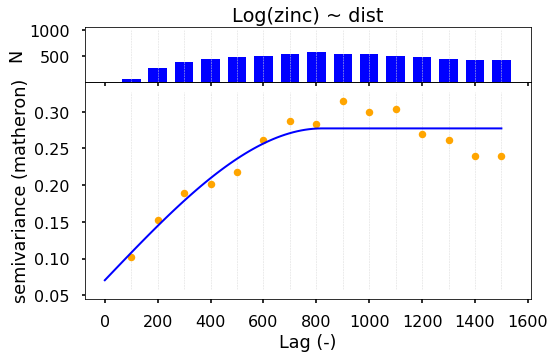

In [10]:
## View variogram
vg = Variogram(coordinates=pd.concat([meuse.data_krg.x,meuse.data_krg.y], axis = 1).values, 
                                      values=meuse.data_krg.res.values, normalize=False, 
                                      use_nugget = True, model = 'spherical',maxlag = 1500, n_lags=15)

ax = Variogram_plot(vg, fig_title = 'Log(zinc) ~ dist', axes=None, grid=True, show=True, hist=True)

### Let's plot the predictions on a map

We can then plot on a map the predictions from the kriging model (both the mean and the standard deviation). 

In [11]:
## View universal kriging results
def view_results_krg(changed):
    clear_output()
    display(dropdown_krg)
    variable = changed['new']
    if(variable == 'mean'):
        description='Predicted (mean) topsoil zinc concentration (in ppm) - log'
        ramp = str(list(np.linspace(start=4, stop=8, num=11)))
        ramp_str = f'opacity(ramp(buckets(${variable},' + ramp + '), Temps), .5)'
    else:
        description='Predicted (std. dev.) topsoil zinc concentration (in ppm) - log'
        ramp = str(list(np.linspace(start=0, stop=0.5, num=11)))
        ramp_str = f'opacity(ramp(buckets(${variable},' + ramp + '), Temps), .5)'
    
    display(
        Map(
        Layer(meuse.data_grid_krg_lonlat,
            f'color: {ramp_str}',
            {'click': [{
                'title': '',
                'value': f'${variable}'
            }]},
            legend={
                'type': 'color-continuous-polygon',
                'prop': 'color',
                'title':   f'{description}'
            }
        ),
        show_info=True
        )
    )

variables = ['mean','sd']
dropdown_krg = widgets.Dropdown(
    options=[v for v in variables],
    value=variables[0],
)

dropdown_krg.observe(view_results_krg, names='value')
view_results_krg({'new': variables[0]})

Dropdown(options=('mean', 'sd'), value='mean')

### Let's compute the predictions accounting for the uncertainty in the spatial field using a Bayesian framework implemented with the INLA/SPDE approach

Kriging methods relies on a known covariance/semi-variogram model. However, both computing the empirical semivariogram and fitting a semivariogram model come with some uncertainty: for example, the results may depend on the binning of the pair-wise distances or the empirical semivariogram may show some unexpected behaviour (e.g. in the example above the semivariance increases with distance up to a point and then starts to decrease again). In order to properly account for these uncertainties in the estimates/predictions, the method needs to be implemented in a Bayesian framework (Banerjee et al., 2014). 

Here we will assume a Matérn covariance function and fit the model using the Integrated Nested Laplace Approximation (INLA) with the stochastic partial differential equation (SPDE) approach (Lindgren et al., 2011) implemented in the <b>R-INLA</b> package (http://www.r-inla.org, https://becarioprecario.bitbucket.io/spde-gitbook/).

#### How INLA works

INLA is a nice (fast) approach to find an approximate solutions for Bayesian hierarchical models for Latent Gaussian Models, which assume that the model parameters have a joint Gaussian distribution

\begin{align}
y|\theta \sim \prod_i p\left(y_i|\eta_i,\psi_1\right) \quad \quad \text{Likelihood}  \\
\theta|\psi_1 \sim N\left(0, \Sigma(\psi)\right) \quad \quad \text{Latent field}  \\
\psi  = [\psi_1,\psi_2] \quad \quad \text{Hyperparameters} \\
\end{align}

e.g. $g\left(\eta_i\right)  = \beta_0 + \sum_j \beta_j x_j $ for a Generalized Linear Model.

1. Assume that the components of the latent Gaussian fields are conditionally independent 

    \begin{equation*} \theta_i \: \bot \: \theta_j|\theta_{-ij} \end{equation*}

    with the consequence that the precision matrix $Q = \Sigma^{-1}$ is sparse. This specification is know as Gaussian Markov Random Field (GMRF).

3. Compute the posterior distribution of the model parameters

    \begin{equation*} p\left(\theta_i|y\right) = \int p\left(\theta_i,\psi|y \right) d\psi 
                                               = \int p\left(\theta_i|\psi, y \right) p\left(\psi|y \right) d\psi 
    \end{equation*}
    
    by approximating $p\left(\psi|y \right)$ and $p\left(\theta_i|\psi, y \right)$ using Laplace approximation (i.e. the normal approximation around the mode, http://www2.stat.duke.edu/~st118/sta250/laplace.pdf)

    \begin{equation*} p\left(\theta_i|y\right) \sim \tilde{p}\left(\theta_i|y\right) \end{equation*}

4. Solve the integral numerically through a finite weighted sum

#### How the SPDE approach works

A Gaussian Process (GP) with Matérn covariance can be obtained as the weak solution to a stochastic partial differential equation (SPDE, Lindgren et al., 2011)

\begin{equation*} (\kappa^2 - \Delta^2)^{\frac{\alpha}{2}} \big(\tau \; u(\mathbf{s})\big) =  U(\mathbf{s}) \end{equation*}

where $\Delta^2$ is the Laplacial, $\kappa^2$ is a range parameter and $U(\mathbf{s})$ is spatial white noise and for integer values of $\alpha = \nu + d/2$ the solution of the SPDE has a sparse precision matrix (i.e. is Markov).  This solution can be represented as a discretized approximation of the continuous using basis functions $\phi_g(\mathbf{s})$ and Gaussian weights $u_g$ defined on a triangular mesh that represents the GP in the "best possible way" 

\begin{equation*} \xi (\mathbf{s}) = \sum_{g=1}^G \phi_g(\mathbf{s}) \; \xi_g  \end{equation*}

where the weights can be determined plugging in this discretized approximation into the SPDE. $\xi (\mathbf{s})$ represents the approximated solution to the SPDE and is characterized by a sparse prercision matrix (i.e. $\xi (\mathbf{s})$ is a Gaussian Markov Random field), which allows fast computationas. 

For an in-depth introduction to R-INLA and the INLA/SPDE approach see https://inla.r-inla-download.org/r-inla.org/tutorials/spde/spde-tutorial.pdf.

Details on the INLA/SPDE implementation can be found in the <i>INLAspde</i> function in the <b>func.R</b> script.

In [9]:
%%R
meuse_data[["meuse"]]$log_zinc <- log(meuse_data[["meuse"]]$zinc)
INLAspde(meuse_data[["meuse"]], meuse_data[["meuse.grid"]], 
         family = 'gaussian', response_var = 'log_zinc', predictors = c('dist'), 
         data.crs = CRS("+init=epsg:28992"),
         filename.out = './data/meuse.INLAspde.csv', filename.grid.out = './data/meuse.grid.INLAspde.csv')


Call:
c("inla(formula = ff, family = family, data = inla.stack.data(stack.join, ",  "    spde = spde), verbose = TRUE, control.compute = list(cpo = TRUE, ",  "    dic = TRUE), control.predictor = list(A = inla.stack.A(stack.join), ",  "    compute = TRUE, link = 1))")

Time used:
 Pre-processing    Running inla Post-processing           Total 
         3.9529          9.8660          0.7721         14.5910 

Fixed effects:
             mean     sd 0.025quant 0.5quant 0.975quant    mode kld
Intercept  6.6002 0.1289     6.3528   6.5975     6.8629  6.5923   0
dist      -2.7890 0.3857    -3.5538  -2.7885    -2.0278 -2.7872   0

Random effects:
Name	  Model
 spatial.field   SPDE2 model 

Model hyperparameters:
                                            mean       sd 0.025quant 0.5quant
Precision for the Gaussian observations  13.7113   3.4888     8.1203  13.2914
Range for spatial.field                 525.6091 141.5889   303.3296 506.7082
Stdev for spatial.field                   0.4645  

Looking at the results, we can see that there is a clear reduction in the concentration of zinc as distance to the river increases (c.f. "Fixed effects" in the output above), which is consistent with the kriging results. We can load the mesh defined over the study region which was used to compute the approximation to the solution.

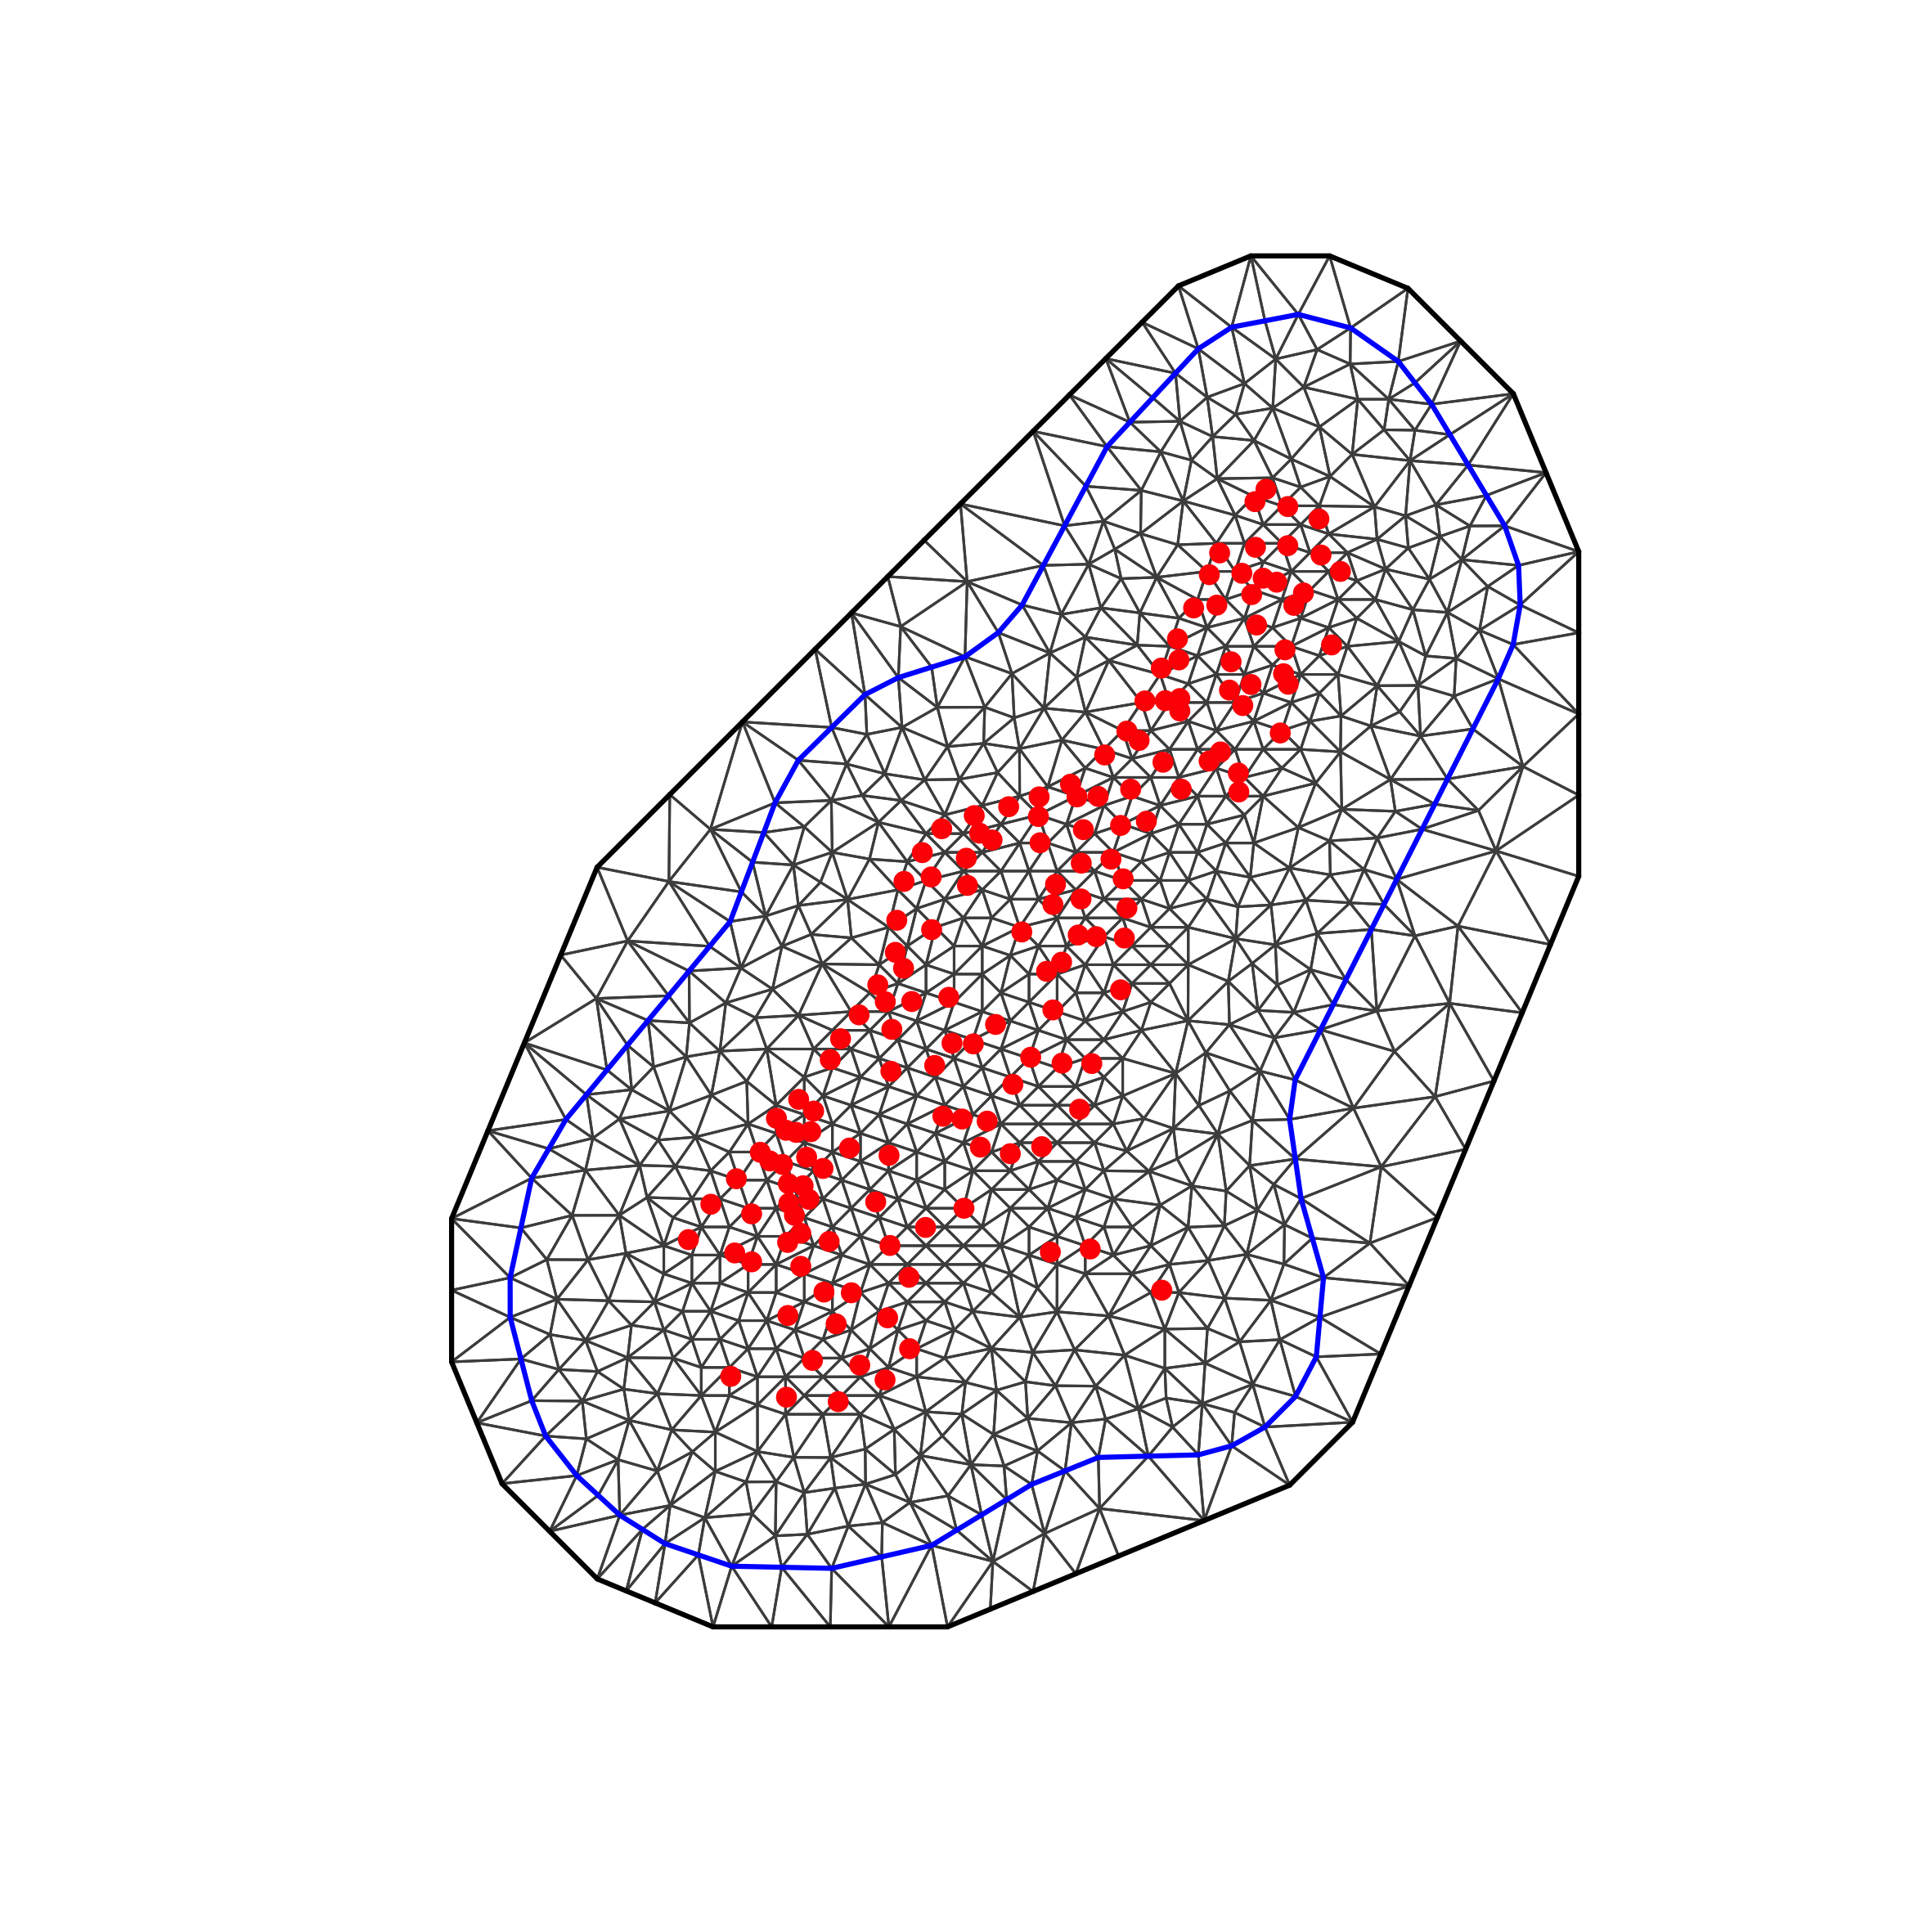

In [10]:
Image("data/meuse.INLAspde_mesh.png",width=700, height=700)

### Let's plot the predictions on a map

We can then plot on a map the predictions from the INLA/SPDE model (both the mean and the standard deviations). The mean estimates are also very similar to  kriging results. On the other hand, prediction standard deviations, which are a measure of the uncertainty, are much smaller for the model fitted with INLA/SPDE.

In [11]:
## Load the INLA/SPDE results
meuse.loadpred_INLAspde()

In [12]:
## View the INLA/SPDE  results
def view_results_INLAspde(changed):
    clear_output()
    display(dropdown_INLA)
    variable = changed['new']
    if(variable == 'mean'):
        description='Predicted (mean) topsoil zinc concentration (in ppm) - log'
        ramp = str(list(np.linspace(start=4, stop=8, num=11)))
        ramp_str = f'opacity(ramp(buckets(${variable},' + ramp + '), Temps), .5)'
    else:
        description='Predicted (std. dev.) topsoil zinc concentration (in ppm) - log'
        ramp = str(list(np.linspace(start=0, stop=0.5, num=11)))
        ramp_str = f'opacity(ramp(buckets(${variable},' + ramp + '), Temps), .5)'
    
    display(
        Map(
        Layer(meuse.data_grid_INLAspde_lonlat,
            f'color: {ramp_str}',
            {'click': [{
                'title': '',
                'value': f'${variable}'
            }]},
            legend={
                'type': 'color-continuous-polygon',
                'prop': 'color',
                'title':  f'{description}'
            }
        ),
        show_info=True
        )
    )

variables = ['mean','sd']
dropdown_INLA = widgets.Dropdown(
    options=[v for v in variables],
    value=variables[0]
)

dropdown_INLA.observe(view_results_INLAspde, names='value')
view_results_INLAspde({'new': variables[0]})

Dropdown(options=('mean', 'sd'), value='mean')

# References

Banerjee S, Gelfand AE, and Carlin BP. (2014). Hierarchical Modeling and Analysis for Spatial Data. Chapman & Hall/CRC.

Bivand RS, Pebesma EJ, and Gómez-Rubio V. (2008). Applied spatial data analysis with R (Vol. 747248717). New York: Springer.

Bivand RS (2017). Revisiting the Boston data set - Changing the units of observation affects estimated willingness to pay for clean air. REGION, 4(1):109-127.

Gilley OW, and Pace RK. (1996). On the Harrison and Rubinfeld data. Journal of Environmental Economics and Management, 31(3):403–405.

Harrison D, and Rubinfeld DL. (1978). Hedonic housing prices and the demand for clean air. Journal of Environmental Economics and Management, 5:81–102.

Lindgren F, Rue H, and Lindström J. (2011). An Explicit Link Between Gaussian Fields and Gaussian Markov Random Fields: The Stochastic Partial Differential Equation Approach (with Discussion). J. R. Statist. Soc. B, 73(4): 423–98.